Licensed under the MIT License (see LICENSE for details) <br />
Written by Stephen Price

# Saving Segmentation Results

This example will take you through taking a model already trained and predicting on set images to save segmentation results for later analysis

In [2]:
import cv2
import json
import numpy as np
import os
from pathlib import Path
import pickle
#import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = Path('..')
sys.path.append(str(root))

from sat_helpers import data_utils, visualize


# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [4]:
EXPERIMENT_NAME = 'satellite'
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 5000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

weights_path = Path(str(root),'examples','powder','satellite_output_auto','model_final_W3.6.pth')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.OUTPUT_DIR = str(Path('..', 'Models', 'SALAS_model-1'))
# make the output directory
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
print(str(model_checkpoints[-1]))
predictor = DefaultPredictor(cfg)  # create predictor object

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
../Models/SALAS_model-1/model_final.pth


# Saving Results to disk
If we save the results to disk, we can then compare them to ground truth annotations to identify perfomrnace of mode;

Annotating: S02_01_SE1_300X14


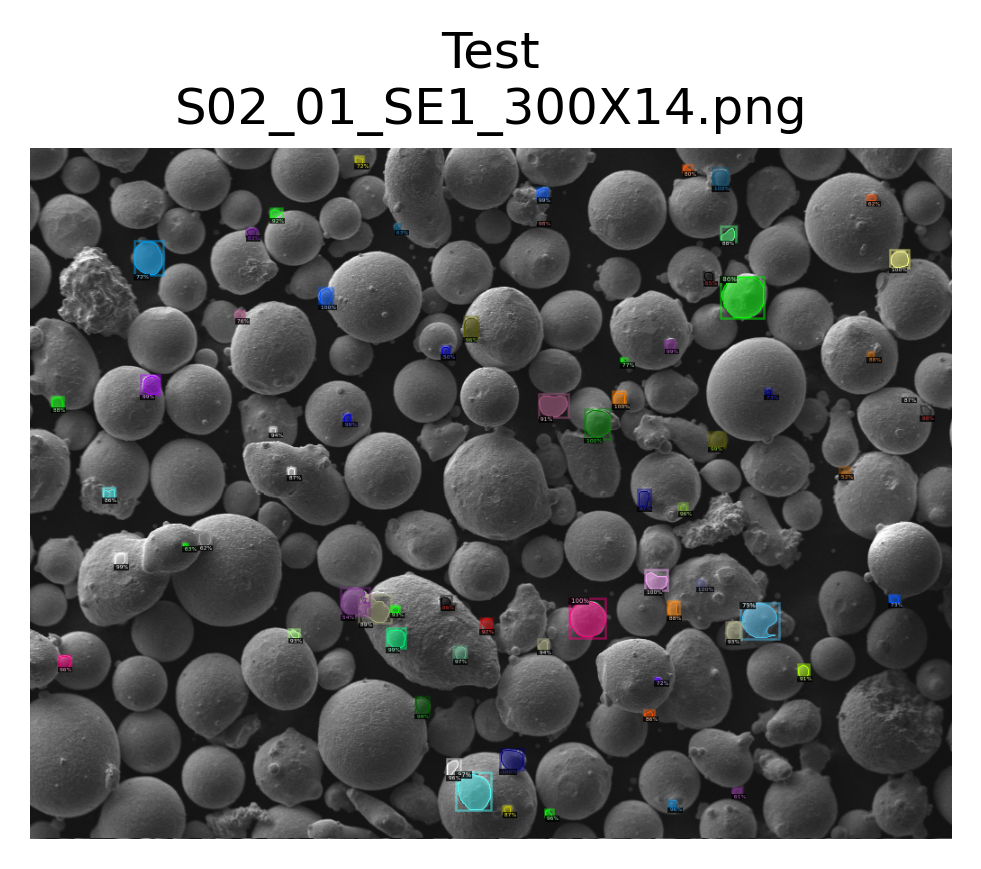

ddict info:
	path: ../data/SEM/S02_01_SE1_300X14.png
	num_instances: 68
Annotating: S03_03_SE1_1250X41


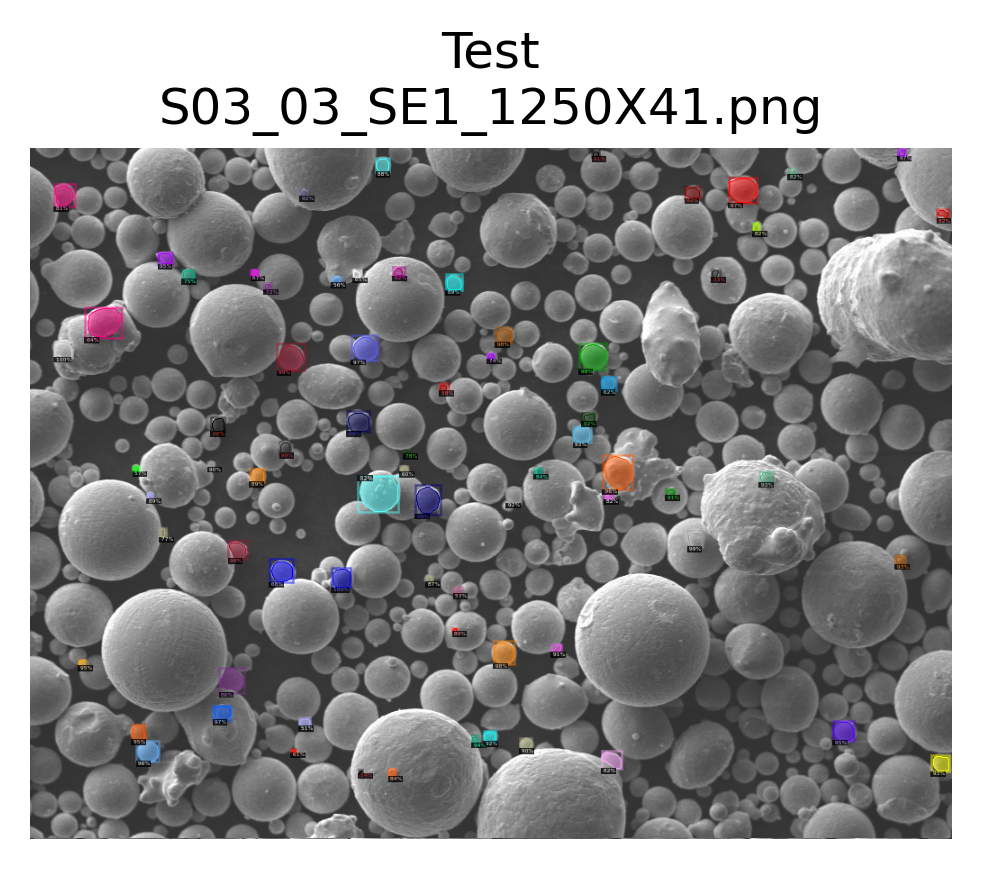

ddict info:
	path: ../data/SEM/S03_03_SE1_1250X41.png
	num_instances: 73
Annotating: S04_02_SE1_1000X50


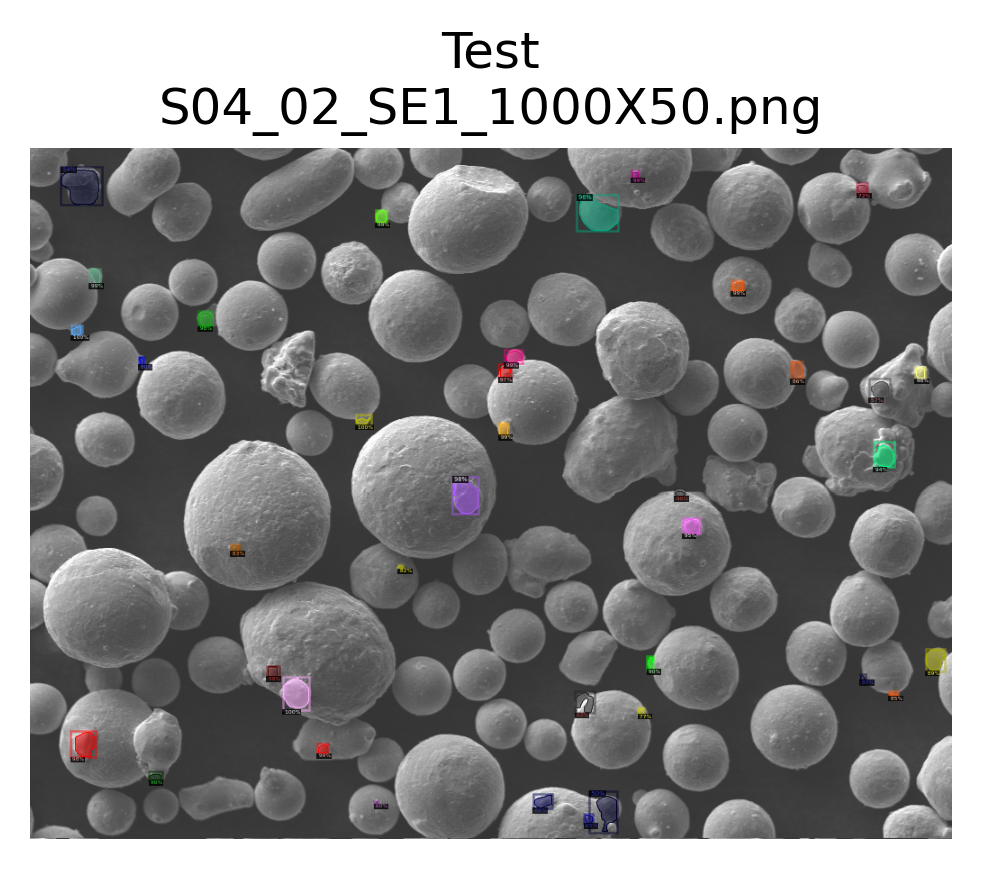

ddict info:
	path: ../data/SEM/S04_02_SE1_1000X50.png
	num_instances: 38
Annotating: S06_01_SE1_500X67


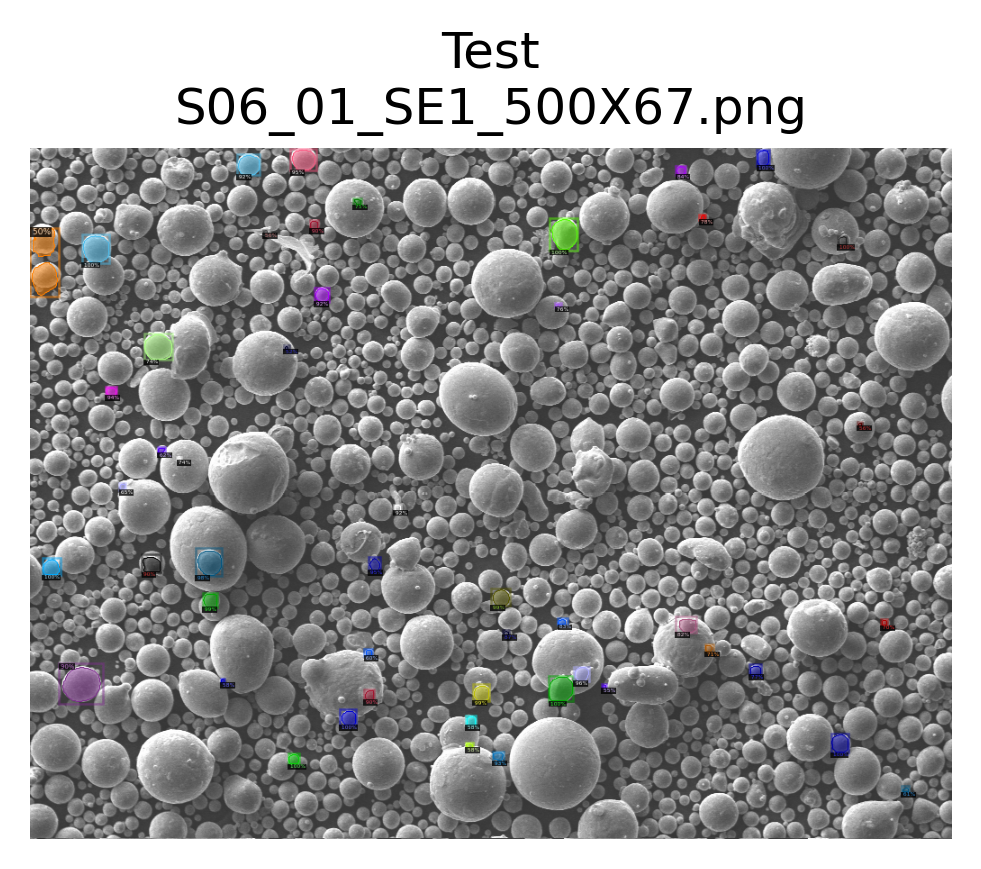

ddict info:
	path: ../data/SEM/S06_01_SE1_500X67.png
	num_instances: 49
Annotating: S08_03_SE1_1000X03


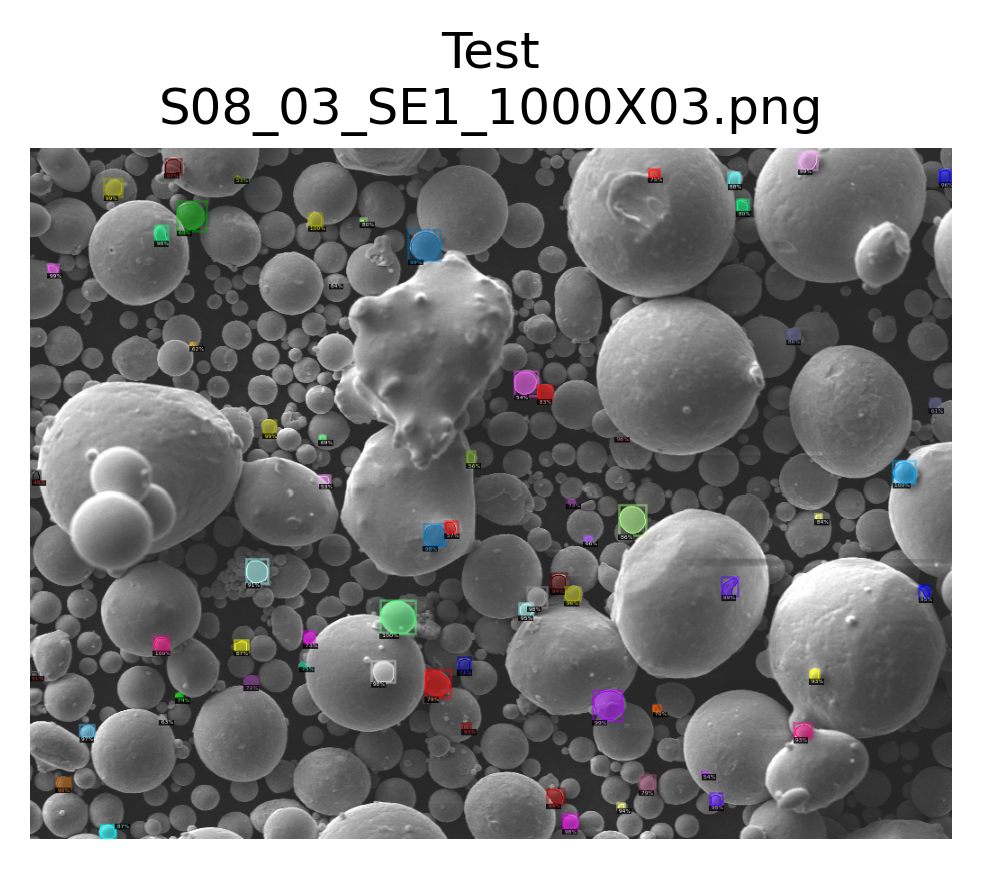

ddict info:
	path: ../data/SEM/S08_03_SE1_1000X03.png
	num_instances: 66
Annotating: HP743_2S_250x


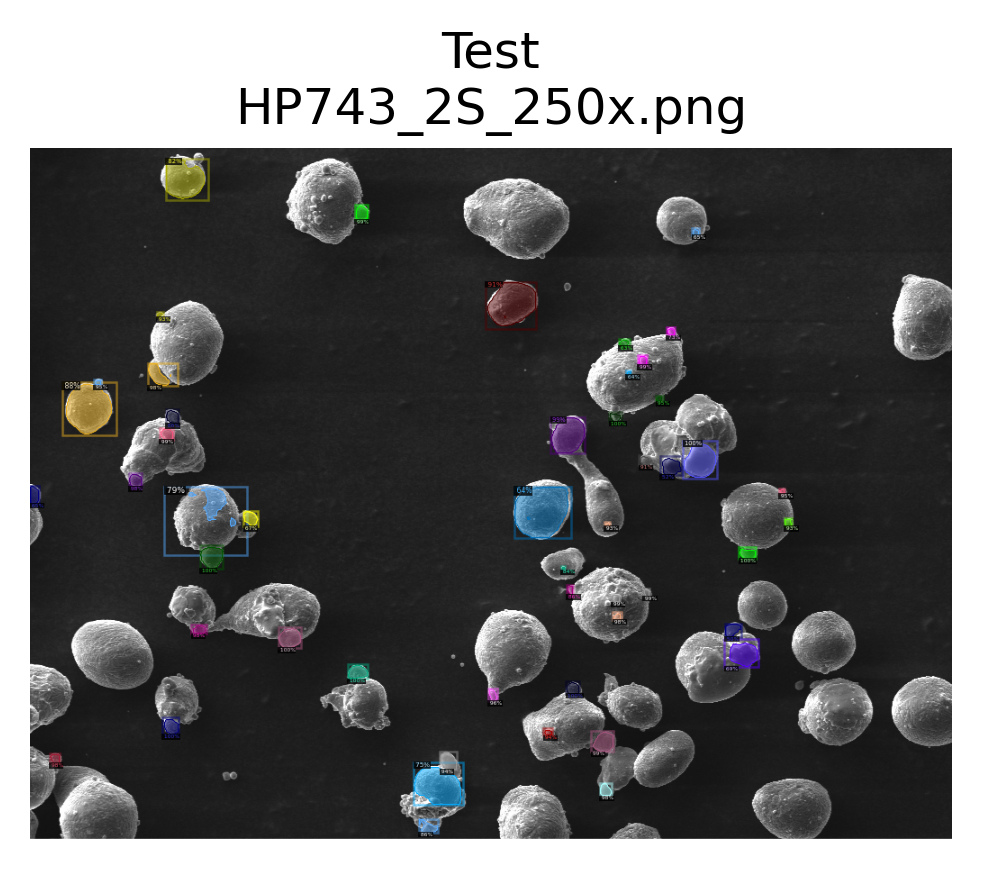

ddict info:
	path: ../data/SEM/HP743_2S_250x.png
	num_instances: 50


In [5]:
results = []  
t = ['S02_01_SE1_300X14', 'S03_03_SE1_1250X41','S04_02_SE1_1000X50',
     'S06_01_SE1_500X67', 'S08_03_SE1_1000X03','HP743_2S_250x'] #Setting a list of images to use for comparison of performnace
for f in t:
    print("Annotating: " + f)
    img_path = Path(root, 'data', 'SEM', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    results.append(data_utils.format_outputs(img_path, 'Validation', outs))
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement        
# save to disk
with open(Path(root, 'data', 'segmentation_results-example.pickle'), 'wb') as f:
    pickle.dump(results, f)